In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Dataset imports:
from data.dataset_alt import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split, WeightedRandomSampler
from torchvision.models import resnet50

# Model imports:
from model_alt_2 import *

# Train and evaluation imports:
from train import train, train2
from evaluate import evaluate, evaluate2

# Custom Transforms imports:
from custom_transforms import *

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math
import random

# SKLearn imports:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Other imports:
from tqdm import tqdm

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda', index=0)

In [6]:
torch.backends.cudnn.benchmark = True

# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [7]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [8]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.

# Creating the sharpness transform:
sharpen = Sharpen(sharpness_factor=3.0)
original_image_dim = (450, 600)

# Defining the new image dimension:
resize_fraction = 1

new_height = int(original_image_dim[0] * resize_fraction)
new_width = int(original_image_dim[1] * resize_fraction)
image_dim = (new_height, new_width)

train_transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean, std),
#                 T.RandomHorizontalFlip(p=0.4),
#                 T.RandomVerticalFlip(p=0.4),
#                 T.RandomGrayscale(p=0.25),
#                 T.RandomAutocontrast(p=0.2),        
#                 T.RandomRotation(degrees=10),
#                 T.GaussianBlur(kernel_size=5, sigma=(0.1, 0.2)),
#                 T.ColorJitter(brightness=0.5, hue=0.3, saturation=0.5),
#                 T.RandomCrop(CROPPED_IMAGE_DIM, pad_if_needed=True),
                T.RandomApply([
                    T.RandomHorizontalFlip(p=0.85),
                    T.RandomVerticalFlip(p=0.85),
                    T.RandomRotation(degrees=7.5),
#                     T.RandomAutocontrast(p=0.85),
                    T.RandomGrayscale(p=0.1),
#                     T.ColorJitter(brightness=0.5, hue=0.3, saturation=0.5),
#                     T.RandomPerspective(distortion_scale=0.1, p=0.5),
#                     T.GaussianBlur(kernel_size=3, sigma=(0.1, 2))
                ], p=0.6),
                T.Resize(image_dim),
                sharpen]    
        )

val_transform = T.Compose([
                T.ToTensor(),      
                T.Normalize(mean, std),
                T.Resize(image_dim),
                sharpen]    
)

image_preprocessing = T.Compose([
                T.ToTensor(),      
                T.Normalize(mean, std),
                T.Resize(image_dim),
                sharpen]    
)

In [9]:
image_dim

(450, 600)

# Defining the dataset:

In [10]:
# Creating the dataset instance:
test_dataset = SkinDataset(transform=image_preprocessing)

### The dataset class distribution:

In [11]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

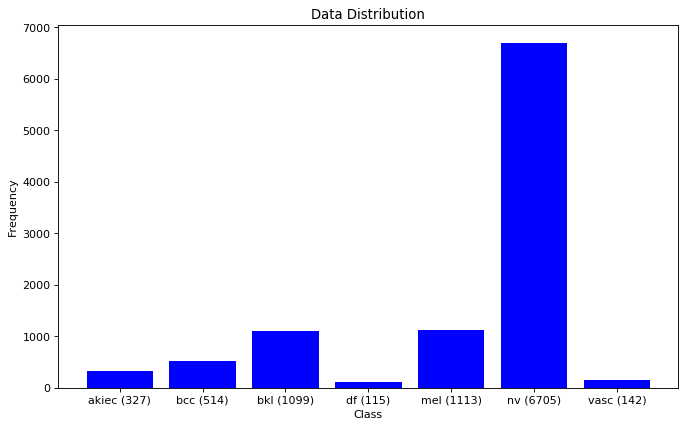

In [12]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [13]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

selected_class = 0
sample_array_3 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2 + sample_array_3

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [14]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32, num_workers=8)

### Creating the model:

In [13]:
model_overfit = Model(num_classes=7, image_dim=image_dim, dropout_prob=[0,0,0])

### The hyperparameters, the loss function and the optimizer:

In [14]:
learning_rate = 6e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_overfit.parameters(), lr=learning_rate)

In [15]:
epochs = 25

### Overfitting the model:

In [16]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Evaluating epoch...


  4%|▍         | 1/25 [00:25<10:14, 25.62s/it]

Epoch: 0 | Train_acc: 23.00% | Val_acc: 23.00% | Loss: 11.42 | Runtime: 25.62 seconds
Evaluating epoch...


  8%|▊         | 2/25 [00:48<09:05, 23.72s/it]

Epoch: 1 | Train_acc: 48.00% | Val_acc: 48.00% | Loss: 17.89 | Runtime: 22.39 seconds
Evaluating epoch...


 12%|█▏        | 3/25 [01:09<08:22, 22.84s/it]

Epoch: 2 | Train_acc: 55.00% | Val_acc: 55.00% | Loss: 10.58 | Runtime: 21.80 seconds
Evaluating epoch...


 16%|█▌        | 4/25 [01:31<07:50, 22.42s/it]

Epoch: 3 | Train_acc: 51.00% | Val_acc: 51.00% | Loss: 2.69 | Runtime: 21.78 seconds
Evaluating epoch...


 20%|██        | 5/25 [01:53<07:23, 22.20s/it]

Epoch: 4 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 3.15 | Runtime: 21.80 seconds
Evaluating epoch...


 24%|██▍       | 6/25 [02:15<06:59, 22.06s/it]

Epoch: 5 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 3.79 | Runtime: 21.78 seconds
Evaluating epoch...


 28%|██▊       | 7/25 [02:36<06:35, 21.97s/it]

Epoch: 6 | Train_acc: 73.00% | Val_acc: 73.00% | Loss: 3.04 | Runtime: 21.79 seconds
Evaluating epoch...


 32%|███▏      | 8/25 [02:58<06:13, 21.97s/it]

Epoch: 7 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.99 | Runtime: 21.98 seconds
Evaluating epoch...


 36%|███▌      | 9/25 [03:20<05:50, 21.93s/it]

Epoch: 8 | Train_acc: 78.00% | Val_acc: 78.00% | Loss: 2.33 | Runtime: 21.84 seconds
Evaluating epoch...


 40%|████      | 10/25 [03:42<05:28, 21.88s/it]

Epoch: 9 | Train_acc: 80.00% | Val_acc: 80.00% | Loss: 1.98 | Runtime: 21.78 seconds
Evaluating epoch...


 44%|████▍     | 11/25 [04:04<05:05, 21.79s/it]

Epoch: 10 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.12 | Runtime: 21.58 seconds
Evaluating epoch...


 48%|████▊     | 12/25 [04:25<04:42, 21.74s/it]

Epoch: 11 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.63 | Runtime: 21.61 seconds
Evaluating epoch...


 52%|█████▏    | 13/25 [04:47<04:21, 21.75s/it]

Epoch: 12 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 1.51 | Runtime: 21.78 seconds
Evaluating epoch...


 56%|█████▌    | 14/25 [05:09<04:00, 21.82s/it]

Epoch: 13 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.64 | Runtime: 21.99 seconds
Evaluating epoch...


 60%|██████    | 15/25 [05:31<03:38, 21.81s/it]

Epoch: 14 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.82 | Runtime: 21.78 seconds
Evaluating epoch...


 64%|██████▍   | 16/25 [05:53<03:16, 21.81s/it]

Epoch: 15 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 2.04 | Runtime: 21.80 seconds
Evaluating epoch...


 68%|██████▊   | 17/25 [06:14<02:54, 21.80s/it]

Epoch: 16 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.07 | Runtime: 21.79 seconds
Evaluating epoch...


 72%|███████▏  | 18/25 [06:36<02:32, 21.74s/it]

Epoch: 17 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.03 | Runtime: 21.59 seconds
Evaluating epoch...


 76%|███████▌  | 19/25 [06:58<02:10, 21.75s/it]

Epoch: 18 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.05 | Runtime: 21.79 seconds
Evaluating epoch...


 80%|████████  | 20/25 [07:20<01:48, 21.77s/it]

Epoch: 19 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 0.72 | Runtime: 21.81 seconds
Evaluating epoch...


 84%|████████▍ | 21/25 [07:41<01:26, 21.71s/it]

Epoch: 20 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.65 | Runtime: 21.58 seconds
Evaluating epoch...


 88%|████████▊ | 22/25 [08:02<01:04, 21.50s/it]

Epoch: 21 | Train_acc: 99.00% | Val_acc: 99.00% | Loss: 0.52 | Runtime: 21.01 seconds
Evaluating epoch...


 92%|█████████▏| 23/25 [08:23<00:42, 21.40s/it]

Epoch: 22 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.41 | Runtime: 21.15 seconds
Evaluating epoch...


 96%|█████████▌| 24/25 [08:45<00:21, 21.34s/it]

Epoch: 23 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.53 | Runtime: 21.20 seconds
Evaluating epoch...


100%|██████████| 25/25 [09:07<00:00, 21.89s/it]

Epoch: 24 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.38 | Runtime: 22.23 seconds


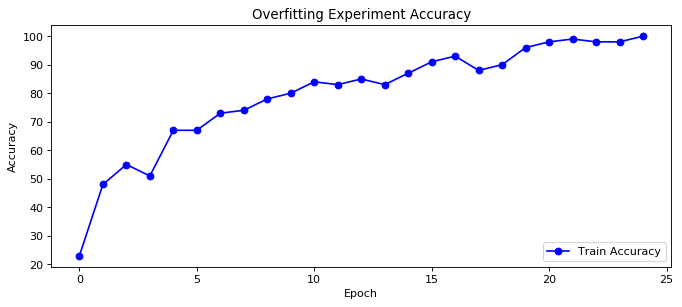

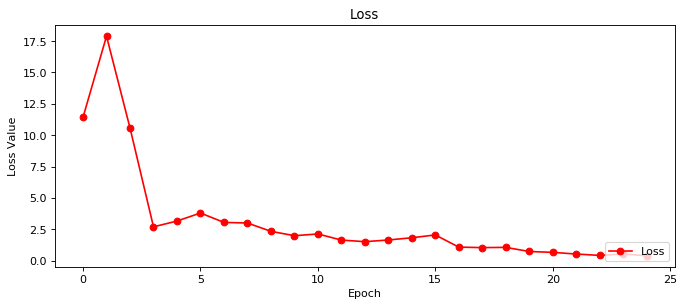

In [17]:
# --- Accuracy: ------------------------------------------------

figure(figsize=(10, 4), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.legend(["Train Accuracy"], loc ="lower right")
plt.show()

# --- Loss: ----------------------------------------------------

figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, 'ro-')
plt.legend(["Loss"], loc ="lower right")
plt.show()

# =============================================================

# Setting up the actual model:

### Defining the Dataset object:

In [15]:
dataset = SkinDataset()

### Splitting the dataset into train, validation, and test sets:

In [16]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.6
validation_proportion = 0.2
test_proportion = 0.2

# Defining all possible indecies to create a dataset with:
all_indecies = np.arange(len(dataset))

# --- Defining the sizes of the splits: ----------------------------------------------

# 1) The train set size:
train_size = math.ceil(train_proportion * len(all_indecies))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(all_indecies))

# 3) The test set size:
test_size = math.floor(test_proportion * len(all_indecies))

np.random.shuffle(all_indecies)

# --- Defining the indecies for each split: ------------------------------------------
train_set_ind = np.copy(all_indecies[0: train_size])
val_set_ind = np.copy(all_indecies[train_size : train_size + validation_size])
test_set_ind = np.copy(all_indecies[train_size + validation_size : train_size + validation_size + test_size])

# --- Defining the train, validation, and test sets: ---------------------------------

train_set = SkinDataset(transform=train_transform, indecies=train_set_ind)
validation_set = SkinDataset(transform=val_transform, indecies=val_set_ind)
test_set = SkinDataset(transform=val_transform, indecies=test_set_ind)

### Saving the test set so it can be used again for evaluation:

In [17]:
# Defining the path where the test indecies will be saved:
save_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', 'test_split_indecies_2.txt')

with open(save_path, 'w') as file:
    test_dict = {'test_indecies' : str(list(test_set_ind))}
    json_dump = json.dumps(test_dict)
    file.write(json_dump)

## Plotting the train data distribution before augmentation of all the splits

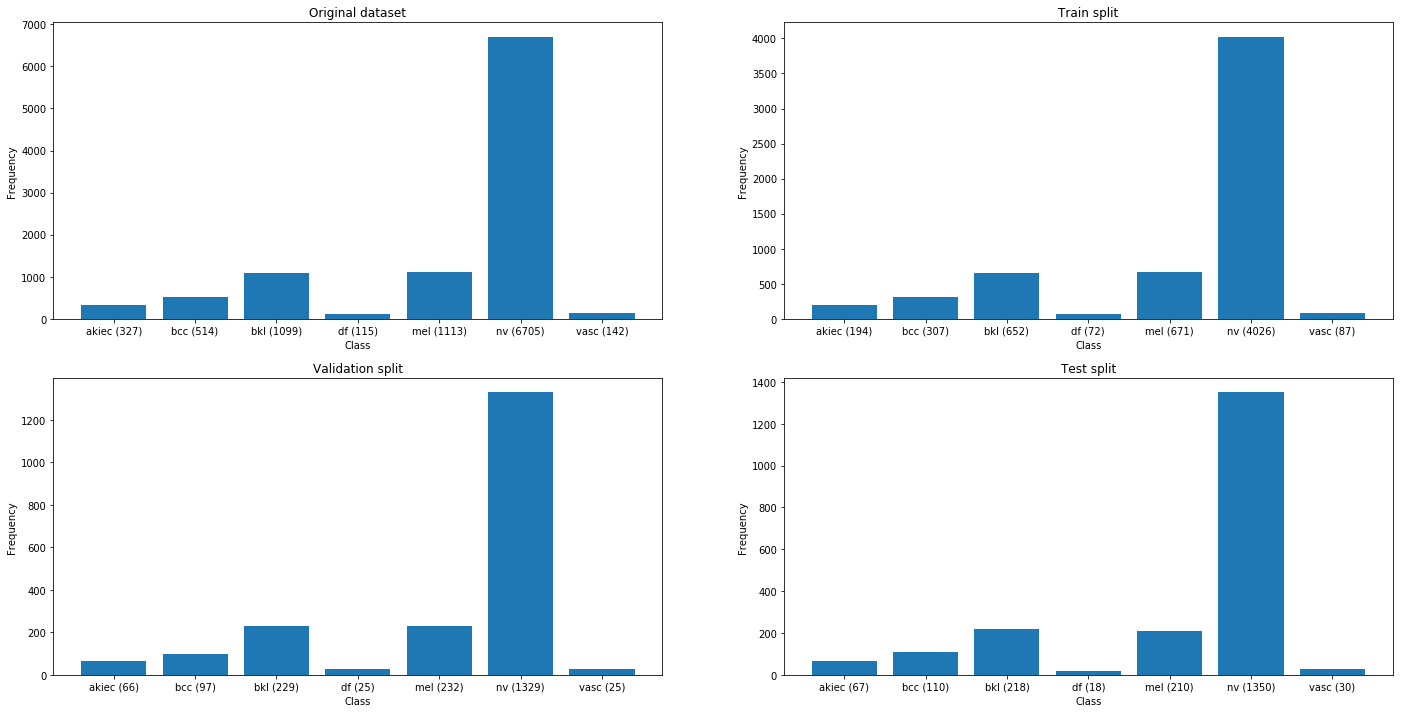

In [18]:
fig, axarr = plt.subplots(2, 2)

fig_size = 12

fig.set_figwidth(fig_size * 2)
fig.set_figheight(fig_size)

titles = ['Original dataset', 'Train split', 'Validation split', 'Test split']
splits = [dataset, train_set, validation_set, test_set]

for ax, split, title in zip(axarr.flatten(), splits, titles):
    data_dist = split.get_data_distribution()
    
    y = list(data_dist.values())
    x = [f'{label} ({count})' for label, count in data_dist.items()]
    
    ax.set_title(title)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.bar(x, y)
    

# Visualizing the preprocessed and the original data:

In [19]:
train_original = SkinDataset(indecies=train_set_ind)
train_preprocessed = SkinDataset(transform=image_preprocessing, indecies=train_set_ind)

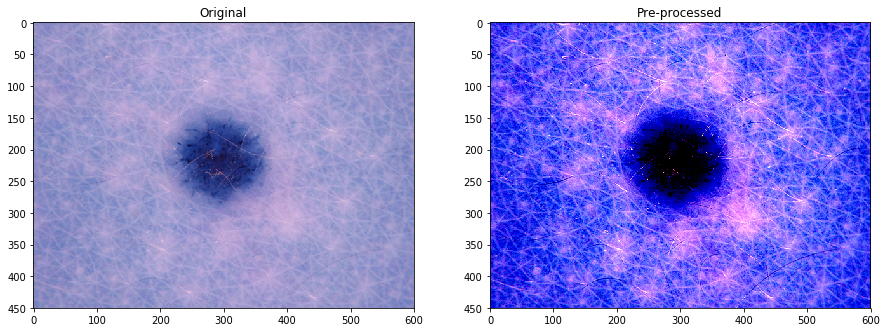

In [20]:
fig, axarr = plt.subplots(1,2)

fig.set_figheight(15)
fig.set_figwidth(15)

index = random.randint(0, len(train_original))

# Retrieving the images:
original_image = train_original[index][0]
preprocessed_image = train_preprocessed[index][0]

# Converting the images to numpy arrays so they can be plotted by matplotlib:
original_image = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
preprocessed_image = np.transpose(preprocessed_image.cpu().detach().numpy(), (1, 2, 0))

axarr[0].set_title('Original')
axarr[1].set_title('Pre-processed')

axarr[0].imshow(original_image)
axarr[1].imshow(preprocessed_image)

# Oversampling the data:

This will be done using the weighted random sampler in PyTorch

### 1) Calculating the weights for the sampler

In [21]:
# Calculating the weights of each class:
weights = np.array(list(train_set.get_data_distribution().values()))
weights = 1 / weights

# Assiging the weights to the images:
image_weights = [weights[i] for i in train_set.mapped_labels]

### 2) Creating the sampler:

In [22]:
sampler = WeightedRandomSampler(weights=image_weights, num_samples=len(train_set), replacement=True)

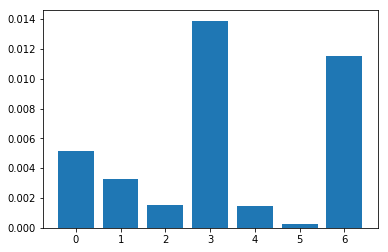

In [23]:
plt.bar(np.arange(7), weights)
plt.show()

# Visualizing the a random subset of the train images:

### Getting the sample:

In [24]:
sample_size = 16
index_subsample = np.random.choice(range(len(train_set_ind)), sample_size)

### Plotting the images:

In [25]:
fig, axarr = plt.subplots(4, 4)

fig_size = 16

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

for ax, ind in zip(axarr.flatten(), index_subsample):
    # Getting the image:
    image = train_set[ind][0]
    # Converting the image to numpy and applying transpose on its
    # dimension so it can be plotted by matplotlib:
    image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
    # Getting the image label and id:
    label = train_set[ind][1]
    title = f'{label}'
    
    ax.set_title(title)
    ax.imshow(image)

### Creating the DataLoader objects:

In [26]:
train_batch_size, validation_batch_size, test_batch_size = 42, 42, 42

# Setting the num_workers to the number of cores on this machine.
num_workers = 8

# train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
train_loader = DataLoader(train_set, sampler=sampler, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=test_batch_size, num_workers=num_workers, pin_memory=True)

# Creating the model:

In [27]:
model = Model(num_classes=dataset.num_classes, image_dim=image_dim)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=False)

### Defining the optimizer, criterion, and hyperparameters:

[0.6386825  0.6163385  0.54540323 0.66214784 0.54141434 0.06459824
 0.65930267]


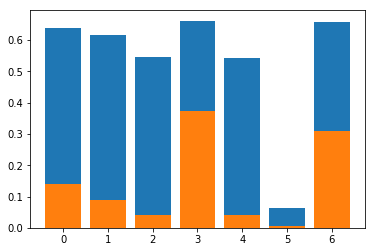

In [28]:
learning_rate = 1e-3
# weight_decay = 1e-4

# --- Defining the optimizer: ---------------------------------------------------------
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Defining the learning rate schedular:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=23, gamma=0.1)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 45], gamma=0.1)


base_lr = 1e-7
max_lr = 5e-3
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
#                                         step_size_up=train_batch_size//2,
#                                         step_size_down=train_batch_size//2)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_batch_size, eta_min=1e-9)

# scheduler = None
 
# --- Defining the loss function: -----------------------------------------------------
data_dist = np.array(list(train_set.get_data_distribution().values()))
class_weights = 1  / data_dist
class_weights = class_weights / np.sum(class_weights)


f = lambda a, m, x: 1 / (1 + np.exp((m - x) / a))
x = class_weights
m, a = np.min(x), - 0.9
x = (data_dist - np.mean(data_dist)) / np.std(data_dist)
weights = f(a, m, x)

# class_weights = torch.Tensor(class_weights).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
# class_weights
print(weights)
plt.bar(np.arange(7), weights)
plt.bar(np.arange(7), class_weights)
plt.show()

# weights = torch.Tensor(weights).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights).to(device)
criterion = nn.CrossEntropyLoss()

### Defining the number of epochs:

In [30]:
epochs = 20

# Training the model

In [31]:
total_loss, epoch_durations, accuracies_train, accuracies_validation, lrs = train2(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                                  verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating epoch...


  5%|▌         | 1/20 [01:47<34:00, 107.41s/it]

Epoch: 0 | Train_acc: 23.27% | Val_acc: 5.39% | Loss: 435.84 | Runtime: 107.41 seconds
Evaluating epoch...


 10%|█         | 2/20 [03:31<31:40, 105.60s/it]

Epoch: 1 | Train_acc: 41.44% | Val_acc: 34.10% | Loss: 245.03 | Runtime: 104.34 seconds
Evaluating epoch...


 15%|█▌        | 3/20 [05:15<29:39, 104.70s/it]

Epoch: 2 | Train_acc: 45.52% | Val_acc: 51.42% | Loss: 213.19 | Runtime: 103.62 seconds
Evaluating epoch...


 20%|██        | 4/20 [06:59<27:53, 104.59s/it]

Epoch: 3 | Train_acc: 45.40% | Val_acc: 42.94% | Loss: 206.45 | Runtime: 104.41 seconds
Evaluating epoch...


 25%|██▌       | 5/20 [08:43<26:06, 104.43s/it]

Epoch: 4 | Train_acc: 49.44% | Val_acc: 47.98% | Loss: 200.56 | Runtime: 104.16 seconds
Evaluating epoch...


 30%|███       | 6/20 [10:28<24:22, 104.44s/it]

Epoch: 5 | Train_acc: 50.29% | Val_acc: 47.33% | Loss: 194.63 | Runtime: 104.46 seconds
Evaluating epoch...


 35%|███▌      | 7/20 [12:12<22:37, 104.45s/it]

Epoch: 6 | Train_acc: 51.99% | Val_acc: 49.23% | Loss: 196.73 | Runtime: 104.46 seconds
Evaluating epoch...


 40%|████      | 8/20 [13:55<20:48, 104.02s/it]

Epoch: 7 | Train_acc: 53.89% | Val_acc: 54.32% | Loss: 186.77 | Runtime: 103.11 seconds
Evaluating epoch...


 45%|████▌     | 9/20 [15:40<19:05, 104.17s/it]

Epoch: 8 | Train_acc: 53.90% | Val_acc: 53.02% | Loss: 182.87 | Runtime: 104.49 seconds
Evaluating epoch...


 50%|█████     | 10/20 [17:24<17:21, 104.12s/it]

Epoch: 9 | Train_acc: 58.10% | Val_acc: 51.02% | Loss: 180.83 | Runtime: 104.03 seconds
Evaluating epoch...


 55%|█████▌    | 11/20 [19:07<15:33, 103.78s/it]

Epoch: 10 | Train_acc: 58.35% | Val_acc: 54.52% | Loss: 174.08 | Runtime: 102.99 seconds
Evaluating epoch...


 60%|██████    | 12/20 [20:51<13:50, 103.87s/it]

Epoch: 11 | Train_acc: 58.65% | Val_acc: 53.02% | Loss: 167.64 | Runtime: 104.08 seconds
Evaluating epoch...


 65%|██████▌   | 13/20 [22:34<12:04, 103.52s/it]

Epoch: 12 | Train_acc: 58.73% | Val_acc: 57.76% | Loss: 170.25 | Runtime: 102.72 seconds
Evaluating epoch...


 70%|███████   | 14/20 [24:18<10:21, 103.63s/it]

Epoch: 13 | Train_acc: 62.09% | Val_acc: 56.67% | Loss: 166.28 | Runtime: 103.88 seconds
Evaluating epoch...


 75%|███████▌  | 15/20 [26:02<08:38, 103.70s/it]

Epoch: 14 | Train_acc: 62.94% | Val_acc: 58.16% | Loss: 160.01 | Runtime: 103.87 seconds
Evaluating epoch...


 80%|████████  | 16/20 [27:46<06:55, 103.87s/it]

Epoch: 15 | Train_acc: 62.41% | Val_acc: 57.11% | Loss: 160.80 | Runtime: 104.27 seconds
Evaluating epoch...


 85%|████████▌ | 17/20 [29:30<05:12, 104.06s/it]

Epoch: 16 | Train_acc: 62.67% | Val_acc: 54.47% | Loss: 154.48 | Runtime: 104.50 seconds
Evaluating epoch...


 90%|█████████ | 18/20 [31:15<03:28, 104.19s/it]

Epoch: 17 | Train_acc: 64.29% | Val_acc: 57.26% | Loss: 157.60 | Runtime: 104.50 seconds
Evaluating epoch...


 95%|█████████▌| 19/20 [32:59<01:44, 104.20s/it]

Epoch: 18 | Train_acc: 66.18% | Val_acc: 58.56% | Loss: 148.08 | Runtime: 104.21 seconds
Evaluating epoch...


100%|██████████| 20/20 [34:43<00:00, 104.18s/it]

Epoch: 19 | Train_acc: 67.35% | Val_acc: 55.92% | Loss: 146.20 | Runtime: 104.07 seconds


In [33]:
plt.plot(np.arange(2880), lrs)
plt.show()

## Plotting the train and validation accuracies:

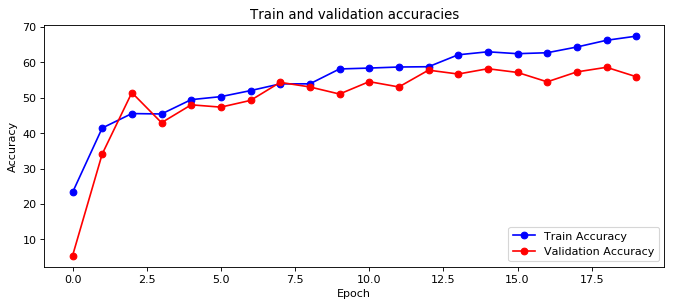

In [34]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.plot(accuracies_validation, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()

## Plotting the loss:

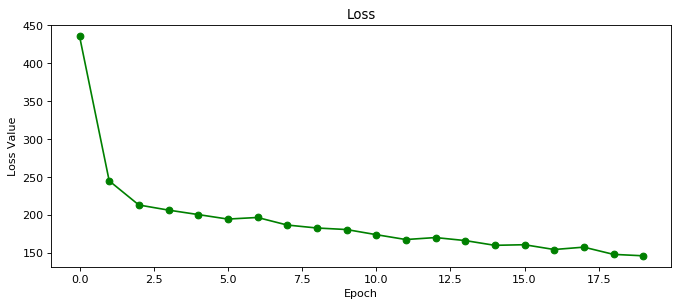

In [35]:
figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")

plt.plot(total_loss, 'go-')

plt.show()

# Evaluating the model with the test set:

In [36]:
test_accuracy = evaluate2(model=model, data_loader=test_loader, device=device)

In [37]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 55.12%


# Visualizing the model:

## 1) Visualizing the filters:

### Getting the filters from the model:

In [38]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [ ]:
# Moving the model to the cpu:
vis_model = model.to('cpu')

filters = []

# Iterating over the layers:
for layer in vis_model.module_list:
    # Iterating over the operations in each layer:
    for op in layer:
        if isinstance(op, torch.nn.Conv2d):
            f = op.weight.data.clone()
            filters.append(f)
#             visTensor(f, ch=0, allkernels=False)
            
plt.axis('off')
plt.ioff()
plt.show()

## 2) Visualizing a convolved random filter with a random image:

In [ ]:
# Getting the filter:
f = filters[0]

# Getting a random image from the test dataset:
index = random.randint(0, len(test_set))
rand_image, label = test_set[index][0], test_set[index][1]
rand_image = rand_image.view(1, *rand_image.shape)

label = dataset.rev_mapping[label]

# Convolving the image with the filter:
conv_im = nn.functional.conv2d(rand_image, f)

# Showing the original image and the convolved image:
fig, axarr = plt.subplots(1, 2)

fig_size = 14

fig.set_figwidth(fig_size)
fig.set_figheight(fig_size)

image = rand_image.cpu().detach().numpy().squeeze()
image = np.transpose(image, (1, 2, 0))

axarr[0].set_title(f'Original | label: {label}')
axarr[1].set_title(f'Convolved | label: {label}')

axarr[0].imshow(image)
axarr[1].imshow(conv_im[:, 0, :, :].squeeze())

## 3) Visualizing a convolved image with all the filters:

In [ ]:
height, width = 8, 4
fig, axarr = plt.subplots(height, width)

# fig.tight_layout()
fig_size = 64

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

conv_im = rand_image
ind = 0
for conv_num, f in enumerate(filters):
    conv_im = nn.functional.conv2d(conv_im, f)
    
    for i in range(f.shape[0]):
        im = conv_im[:, i, :, :].squeeze()
        im = im.cpu().detach().numpy()
        
        ax = axarr.flatten()[ind]
        ax.set_title(f'conv_{conv_num}')
        ax.imshow(im)
        ind += 1

# Class Accuracies

In [ ]:
model = model.to(device)

nb_classes = 7
preds_list = []
confusion_mat = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(test_loader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        for item in preds:
            preds_list.append(item.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_mat[t.long(), p.long()] += 1

In [ ]:
classes = np.unique(test_set.labels)

class_accuracies = confusion_mat.diag() / confusion_mat.sum(1)
class_acc_dict = dict(zip(classes, class_accuracies.tolist()))

for cls, accuracy in class_acc_dict.items():
    print(f'{cls}: {100 * accuracy:.2f}%')

In [ ]:
ground_truth = test_set.mapped_labels

In [ ]:
preds_list = np.array(preds_list)

### Printing the confusion matrix:

In [ ]:
conf_mat = confusion_matrix(ground_truth, preds_list)

In [ ]:
print(conf_mat)

### Testing the model with precision, recall, and f1-score:

In [ ]:
print(classification_report(ground_truth, preds_list))

### Saving the model:

### Creating the path in which the model will be saved:

In [ ]:
path = os.getcwd()
model_name = f'skin_cancer_model_v2'

In [ ]:
MODEL_PATH = os.path.join(path, model_name)

### Saving the model:

In [ ]:
# torch.save(model.state_dict(), MODEL_PATH)